# Simple Decision Tree Classification:

In [548]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [53]:
df1 = pd.read_csv('heart_v2.csv')
df1.head()

age  sex   BP  cholestrol  heart disease
0   70    1  130         322              1
1   67    0  115         564              0
2   57    1  124         261              1
3   64    1  128         263              0
4   74    0  120         269              0

In [55]:
df = df1.copy()

In [57]:
df.shape

(270, 5)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            270 non-null    int64
 1   sex            270 non-null    int64
 2   BP             270 non-null    int64
 3   cholestrol     270 non-null    int64
 4   heart disease  270 non-null    int64
dtypes: int64(5)
memory usage: 10.7 KB


In [61]:
df.isnull().sum().any()

False

In [63]:
df['heart disease'].value_counts()

heart disease
0    150
1    120
Name: count, dtype: int64

In [65]:
round(100*df['heart disease'].value_counts()[1]/len(df), 3)

44.444

The classes are failry balanced.

We dont need to rescale the variables in any CART algorithms lik DT, or RFs.

### Splitting the data into train and test sets:

In [70]:
y = df.pop('heart disease')
X = df

In [72]:
X.head()

age  sex   BP  cholestrol
0   70    1  130         322
1   67    0  115         564
2   57    1  124         261
3   64    1  128         263
4   74    0  120         269

In [74]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: heart disease, dtype: int64

In [76]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=42)

In [78]:
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(189, 4)
(81, 4)
(189,)
(81,)


### Building the Decision Tress with all the default parameters as of now:

In [81]:
dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(Xtrain, ytrain)

DecisionTreeClassifier(max_depth=3)

In [83]:
dtc.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': 3,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'monotonic_cst': None,
 'feature_names_in_': array(['age', 'sex', 'BP', 'cholestrol'], dtype=object),
 'n_features_in_': 4,
 'n_outputs_': 1,
 'classes_': array([0, 1], dtype=int64),
 'n_classes_': 2,
 'max_features_': 4,
 'tree_': <sklearn.tree._tree.Tree at 0x1a7bce1a480>}

In [107]:
dtc.feature_names_in_

array(['age', 'sex', 'BP', 'cholestrol'], dtype=object)

In [125]:
# type(df1['heart disease'].unique())

In [127]:
# [str(c) for c in df1['heart disease'].unique()]

In [129]:
# class_names = [str(c) for c in df1['heart disease'].unique()]

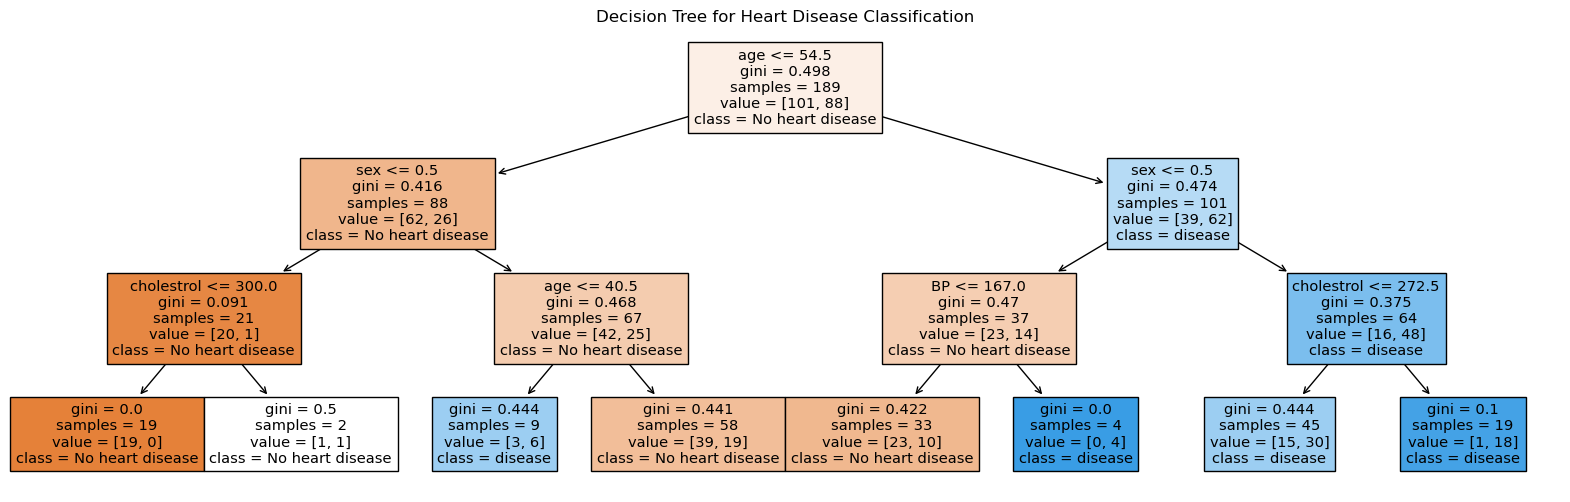

In [133]:
plt.figure(figsize=[20, 6])
plot_tree(decision_tree=dtc, 
          feature_names=dtc.feature_names_in_, 
          filled=True,
         class_names=['No heart disease', 'disease'])

plt.title('Decision Tree for Heart Disease Classification')
plt.show()

## Evaluating the performance of the model on the test set:

In [136]:
ytrain_pred = dtc.predict(Xtrain) 
ytest_pred = dtc.predict(Xtest)

In [188]:
def evaluation(data_type, ytrue, ypred):
    cm = confusion_matrix(ytrue, ypred)
    print(f"\nConfusion Matrix for {data_type} set:")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()
    TN, TP, FN, FP = cm[0,0], cm[1,1], cm[1,0], cm[0,1]
    print('\n')
    print(f"The Accuracy on {data_type} dataset is : {round(accuracy_score(ytrue, ypred), 3)}")
    print(f"The Sensitivity on {data_type} is : {round(recall_score(ytrue, ypred), 3)}")
    print(f"The Specificity on {data_type} is : {round((TN/(TN+FP)), 3)}")
    print('='*150)


Confusion Matrix for Train set:


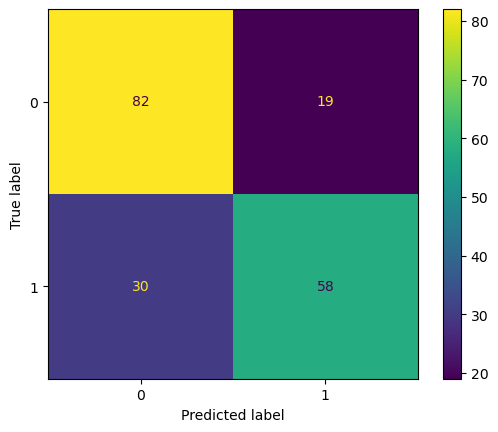



The Accuracy on Train dataset is : 0.741
The Sensitivity on Train is : 0.659
The Specificity on Train is : 0.812

Confusion Matrix for Test set:


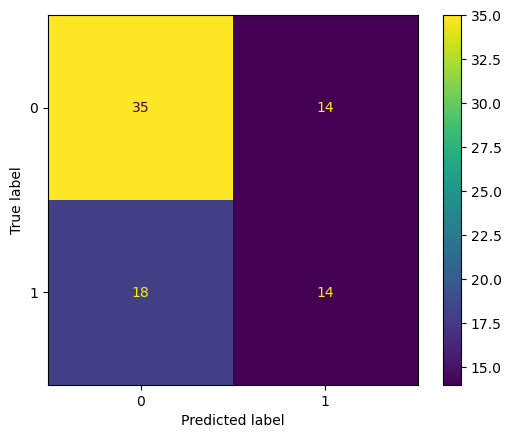



The Accuracy on Test dataset is : 0.605
The Sensitivity on Test is : 0.438
The Specificity on Test is : 0.714


In [190]:
evaluation('Train', ytrain, ytrain_pred)
evaluation('Test', ytest, ytest_pred)

The accuracy on the train set is 74.1% and on the test is 60.5%. We can see that there is a huge gap between bot of them, telling us that this particular vanilla DT model is not performing well.

# PART2: <br>
### Building Decision Tree with Hyperparameters and Tuning them as well as required:

In [737]:
# Creating helper functions to plot trees:
def plot_dt(model, class_names):
    
    # Dynamically adjust the figure size based on the depth of the tree
    depth = model.get_depth()  # Get the depth of the tree
    num_leaves = model.get_n_leaves()  # Get the number of leaves

    # Set width proportional to the number of leaves and height to the depth
    plt.figure(figsize=[num_leaves * 2, depth * 2])
    
    plot_tree(decision_tree=model, 
              feature_names=model.feature_names_in_, 
              filled=True,
              class_names=class_names)
    plt.title('Decision Tree Classification')
    plt.show()

# Creating helper function for the evaluation of trees:
def evaluation(data_type, ytrue, ypred):
    cm = confusion_matrix(ytrue, ypred)
    print(f"\nConfusion Matrix for {data_type} set:")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()
    
    TN, TP, FN, FP = cm[0,0], cm[1,1], cm[1,0], cm[0,1]
    print('\n')
    print(classification_report(ytrue, ypred))
    print('\n')
    print(f"The Accuracy on {data_type} dataset is : {round(accuracy_score(ytrue, ypred), 3)}")
    print(f"The Sensitivity on {data_type} is : {round(recall_score(ytrue, ypred), 3)}")
    print(f"The Specificity on {data_type} is : {round((TN/(TN+FP)), 3)}")
    print('='*150)

In [296]:
dtc1 = DecisionTreeClassifier(min_samples_split=20, random_state=42)
dtc1.fit(Xtrain, ytrain)

ytain_pred = dtc1.predict(Xtrain)
ytest_pred = dtc1.predict(Xtest)

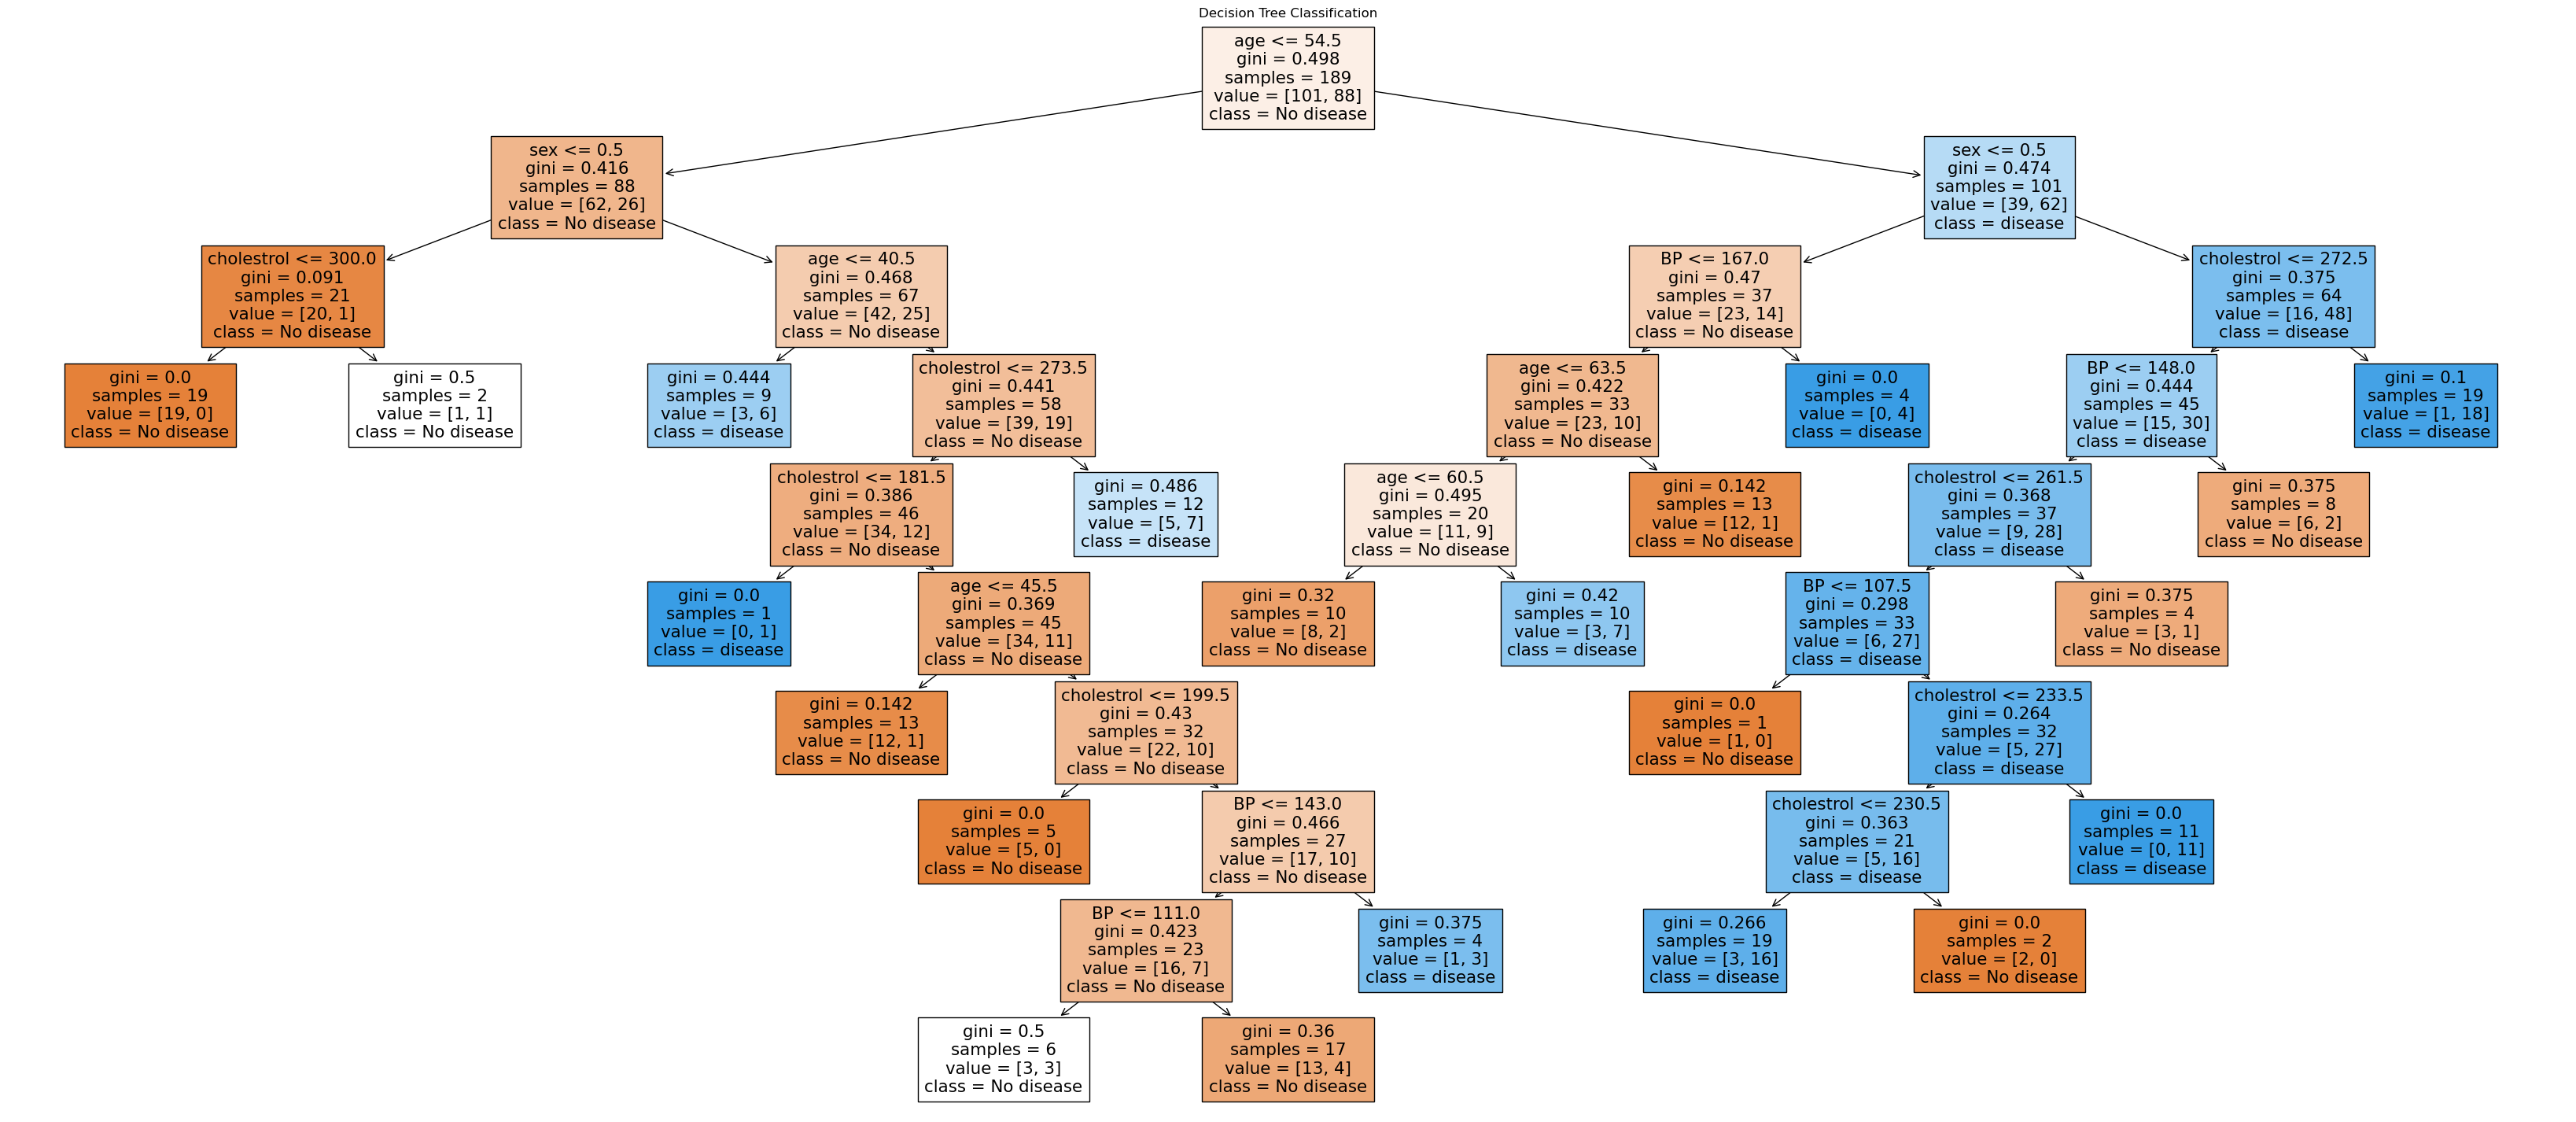

In [298]:
plot_dt(dtc1, ['No disease', 'disease'])


Confusion Matrix for Train set:


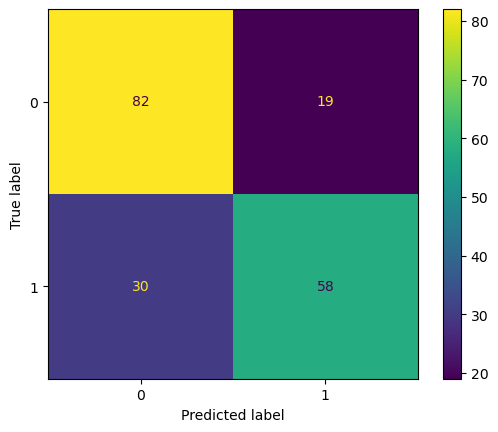



              precision    recall  f1-score   support

           0       0.73      0.81      0.77       101
           1       0.75      0.66      0.70        88

    accuracy                           0.74       189
   macro avg       0.74      0.74      0.74       189
weighted avg       0.74      0.74      0.74       189



The Accuracy on Train dataset is : 0.741
The Sensitivity on Train is : 0.659
The Specificity on Train is : 0.812

Confusion Matrix for Test set:


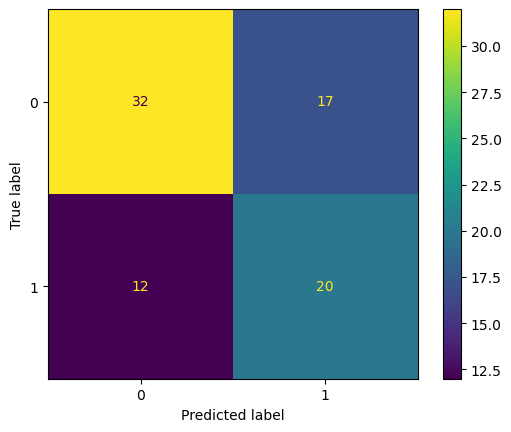



              precision    recall  f1-score   support

           0       0.73      0.65      0.69        49
           1       0.54      0.62      0.58        32

    accuracy                           0.64        81
   macro avg       0.63      0.64      0.63        81
weighted avg       0.65      0.64      0.65        81



The Accuracy on Test dataset is : 0.642
The Sensitivity on Test is : 0.625
The Specificity on Test is : 0.653


In [299]:
evaluation('Train', ytrain, ytrain_pred)
evaluation('Test', ytest, ytest_pred)

We can see that there are some changes in the values of the metrics but not the best one.

Let's try GridSearchCV

#### Let's try changing the criterion from 'gini' to 'entropy':

In [303]:
dtc2 = DecisionTreeClassifier(min_samples_split=20, random_state=42, criterion='entropy')
dtc2.fit(Xtrain, ytrain)

ytain_pred = dtc2.predict(Xtrain)
ytest_pred = dtc2.predict(Xtest)

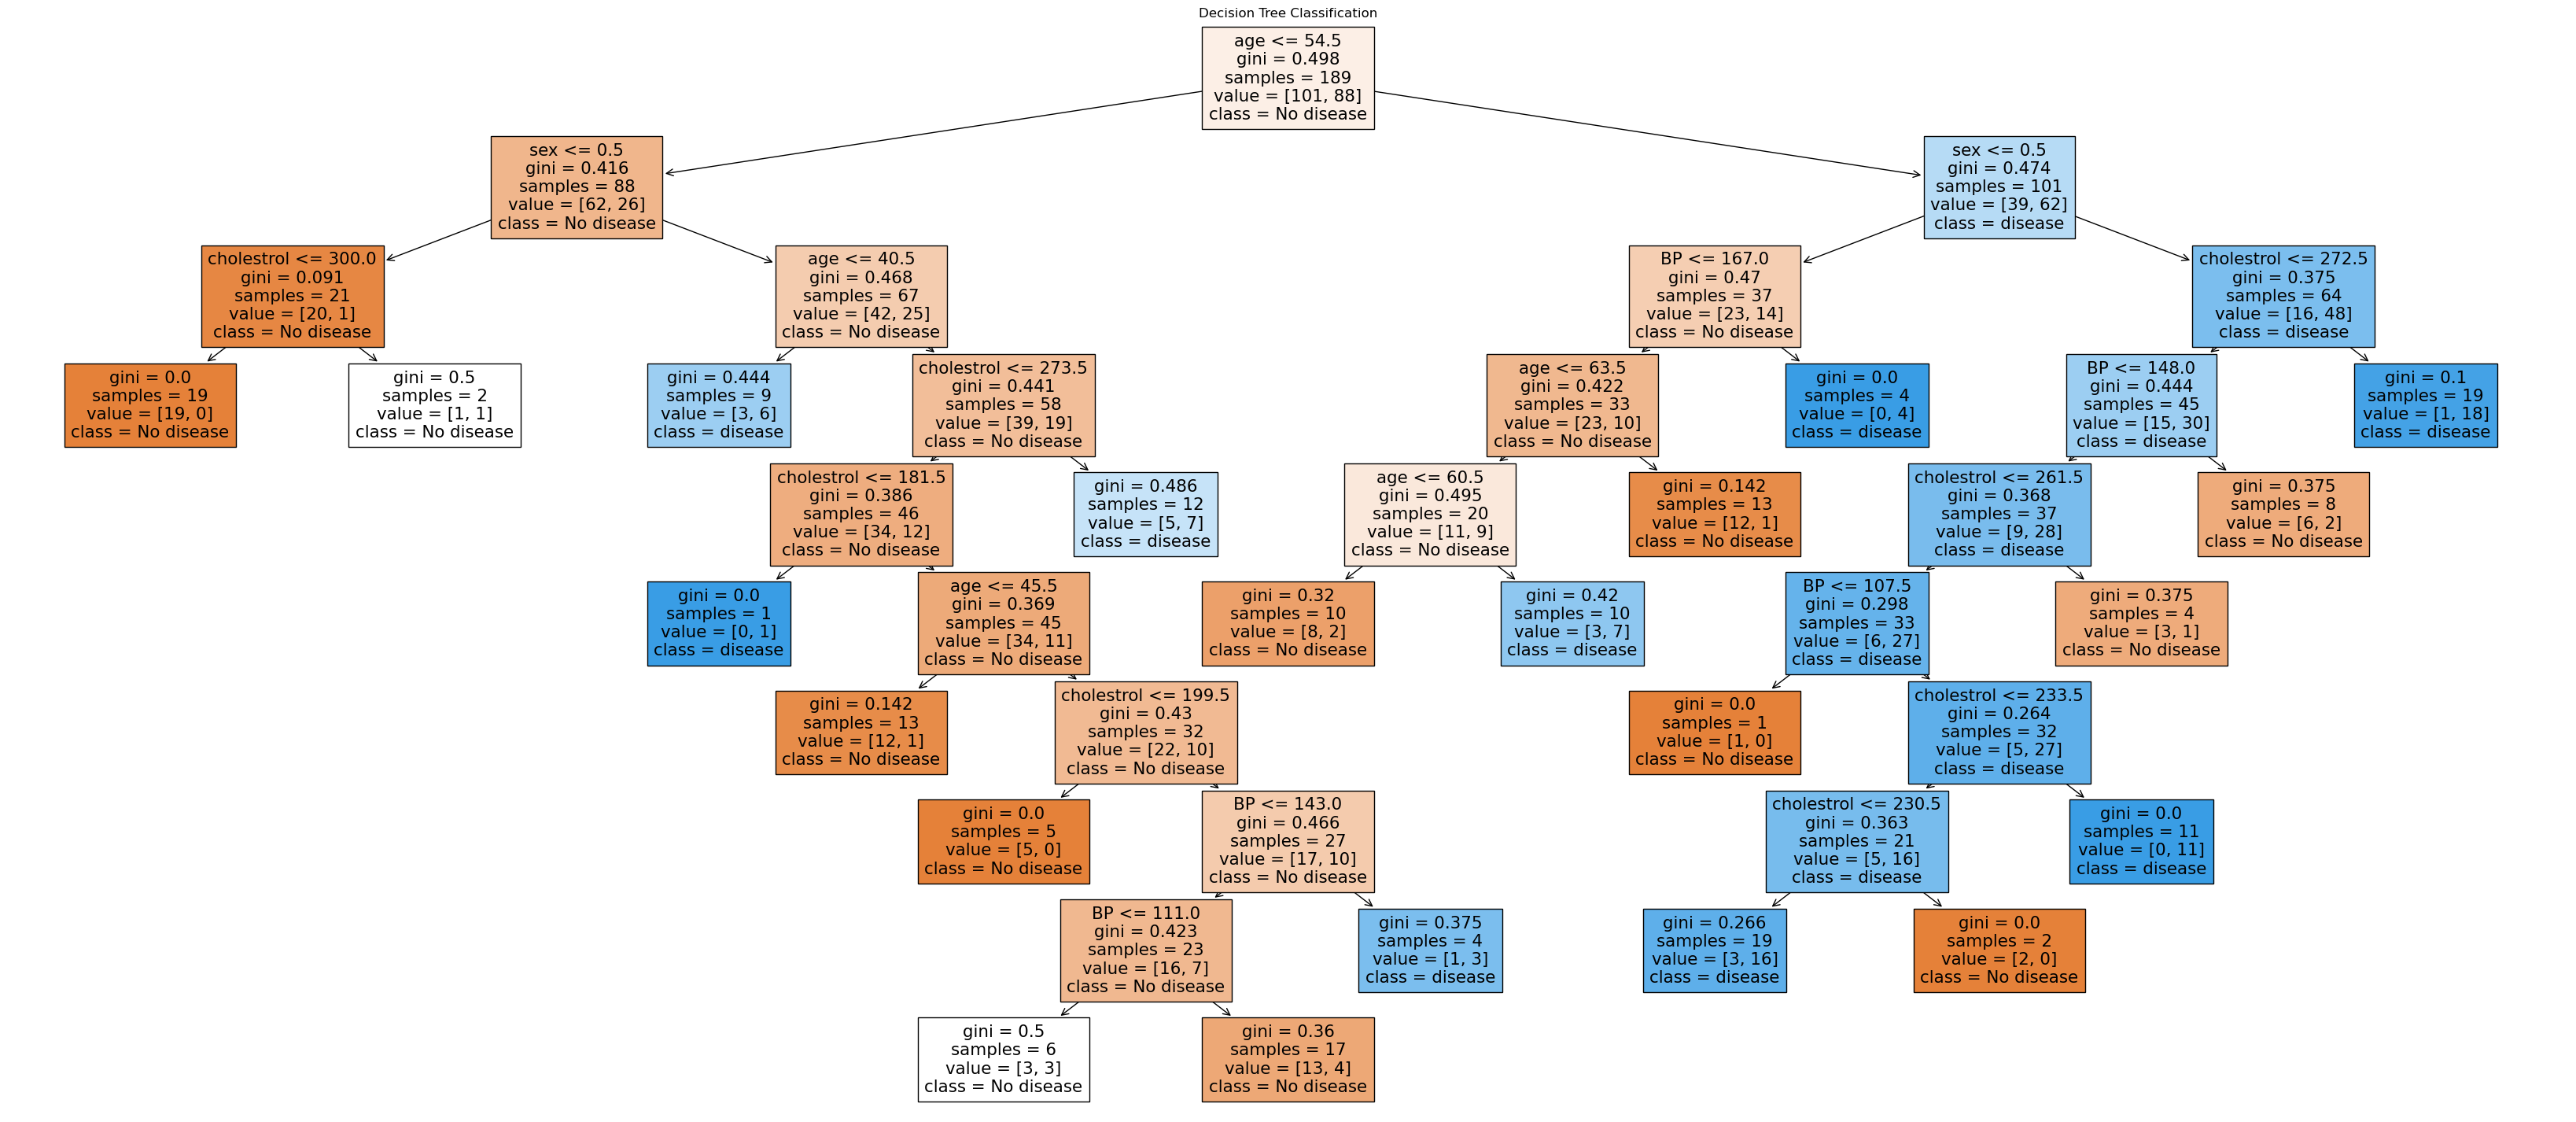

In [305]:
plot_dt(dtc1, ['No disease', 'disease'])


Confusion Matrix for Train set:


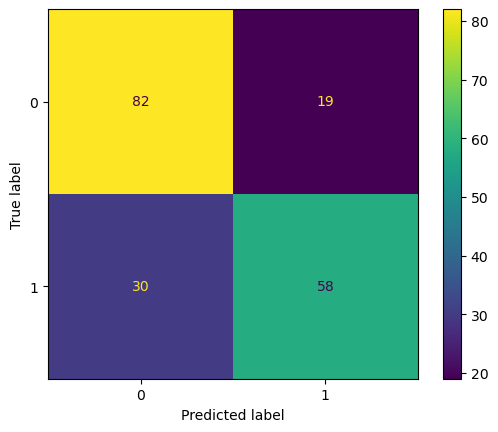



              precision    recall  f1-score   support

           0       0.73      0.81      0.77       101
           1       0.75      0.66      0.70        88

    accuracy                           0.74       189
   macro avg       0.74      0.74      0.74       189
weighted avg       0.74      0.74      0.74       189



The Accuracy on Train dataset is : 0.741
The Sensitivity on Train is : 0.659
The Specificity on Train is : 0.812

Confusion Matrix for Test set:


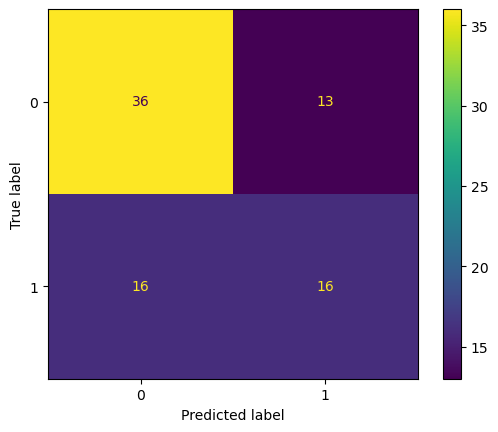



              precision    recall  f1-score   support

           0       0.69      0.73      0.71        49
           1       0.55      0.50      0.52        32

    accuracy                           0.64        81
   macro avg       0.62      0.62      0.62        81
weighted avg       0.64      0.64      0.64        81



The Accuracy on Test dataset is : 0.642
The Sensitivity on Test is : 0.5
The Specificity on Test is : 0.735


In [307]:
evaluation('Train', ytrain, ytrain_pred)
evaluation('Test', ytest, ytest_pred)

##### Changing the Criterion gave us the exact same results. Gini and Entropy are numerically very very close.

### Hyperparamater tuning using GridSearchCV:

In [315]:
dtc.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': 3,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'monotonic_cst': None,
 'feature_names_in_': array(['age', 'sex', 'BP', 'cholestrol'], dtype=object),
 'n_features_in_': 4,
 'n_outputs_': 1,
 'classes_': array([0, 1], dtype=int64),
 'n_classes_': 2,
 'max_features_': 4,
 'tree_': <sklearn.tree._tree.Tree at 0x1a7bce1a480>}

In [321]:
dt = DecisionTreeClassifier(random_state=42)

params_space = {'criterion' : ['gini', 'entropy', 'log_loss'],
                'splitter' : ['best', 'random'],
                'max_depth' : [3,4,5,6,7,8,9,10],
                'min_samples_split' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
                'min_samples_leaf' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}

grid_search_model = GridSearchCV(estimator=dt, 
                                 param_grid=params_space,
                                 scoring='accuracy',      # accuracy because in our case, the classes are failry balanced.
                                 cv=5, 
                                 n_jobs=-1, 
                                 return_train_score=True, 
                                 verbose=1)

In [323]:
%%time
grid_search_model.fit(Xtrain, ytrain)

Fitting 5 folds for each of 17328 candidates, totalling 86640 fits
CPU times: total: 18.5 s
Wall time: 44.7 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [325]:
grid_search_model.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 9,
 'splitter': 'random'}

We can see these are the best params that the GridSearcCV has selected.

In [340]:
cv_results_df = pd.DataFrame(grid_search_model.cv_results_).head()
# cv_results_df.head()

In [354]:
# Top 2 best combinations:

cv_results_df.nlargest(2, columns='mean_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.003411      0.000373         0.002203        0.000398   
2       0.003566      0.000401         0.002004        0.000005   

  param_criterion param_max_depth param_min_samples_leaf  \
0            gini               3                      2   
2            gini               3                      2   

  param_min_samples_split param_splitter  \
0                       2           best   
2                       3           best   

                                              params  ...  mean_test_score  \
0  {'criterion': 'gini', 'max_depth': 3, 'min_sam...  ...         0.672119   
2  {'criterion': 'gini', 'max_depth': 3, 'min_sam...  ...         0.672119   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.038023             6972            0.748344            0.728477   
2        0.038023             6972            0.748344            0.728477   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.761589            0.741722            0.723684   
2            0.761589            0.741722            0.723684   

   mean_train_score  std_train_score  
0          0.740763         0.013673  
2          0.740763         0.013673  

[2 rows x 25 columns]

In [358]:
# the best_score_ attribute refers to the average cross-validated test score (validation score) across the folds of the cross-validation:

grid_search_model.best_score_

0.7301564722617354

In [360]:
final_dt = grid_search_model.best_estimator_
final_dt

DecisionTreeClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=9,
                       random_state=42, splitter='random')

In [362]:
ytrain_pred = final_dt.predict(Xtrain) 
ytest_pred = final_dt.predict(Xtest)


Confusion Matrix for Train set:


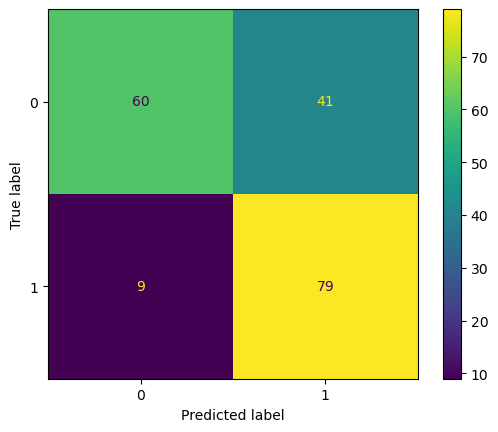



              precision    recall  f1-score   support

           0       0.87      0.59      0.71       101
           1       0.66      0.90      0.76        88

    accuracy                           0.74       189
   macro avg       0.76      0.75      0.73       189
weighted avg       0.77      0.74      0.73       189



The Accuracy on Train dataset is : 0.735
The Sensitivity on Train is : 0.898
The Specificity on Train is : 0.594

Confusion Matrix for Test set:


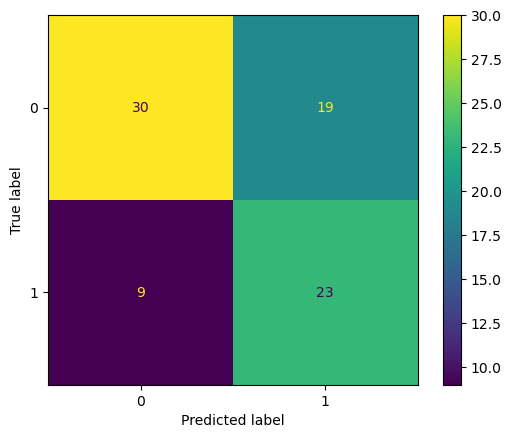



              precision    recall  f1-score   support

           0       0.77      0.61      0.68        49
           1       0.55      0.72      0.62        32

    accuracy                           0.65        81
   macro avg       0.66      0.67      0.65        81
weighted avg       0.68      0.65      0.66        81



The Accuracy on Test dataset is : 0.654
The Sensitivity on Test is : 0.719
The Specificity on Test is : 0.612


In [366]:
evaluation('Train', ytrain, ytrain_pred)
evaluation('Test', ytest, ytest_pred)

These is the best that a Decision Tree could go for our dataset with the best hyperparameter tuning.

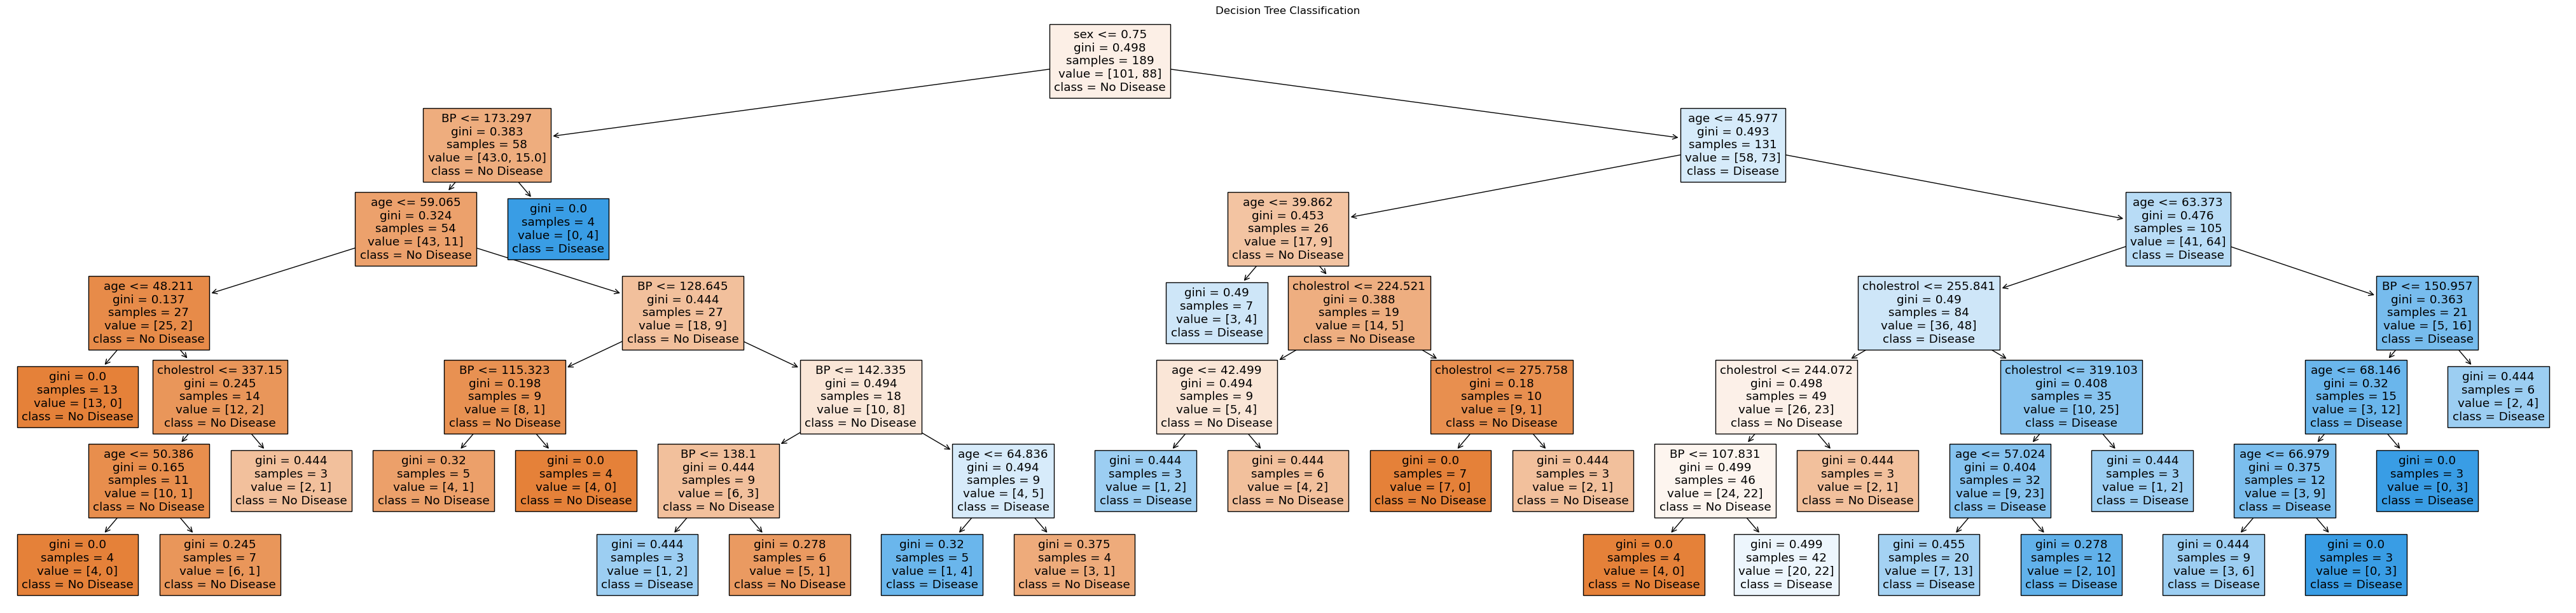

In [369]:
plot_dt(final_dt, ['No Disease', 'Disease'])

-------------------

# Decision Tree Regression:

In [741]:
df = pd.read_csv('Housing.csv')
df.head()

price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished

In [743]:
df.shape

(545, 13)

In [745]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [747]:
df.isnull().sum().any()

False

In [749]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [751]:
num_vars = df.select_dtypes(include='number').columns
num_vars

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking'], dtype='object')

In [753]:
cat_vars = df.select_dtypes(include='object').columns
cat_vars

Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [755]:
len(cat_vars)

7

In [757]:
for i in cat_vars:
    print(i, df[i].unique())
    print('-'*50)

mainroad ['yes' 'no']
--------------------------------------------------
guestroom ['no' 'yes']
--------------------------------------------------
basement ['no' 'yes']
--------------------------------------------------
hotwaterheating ['no' 'yes']
--------------------------------------------------
airconditioning ['yes' 'no']
--------------------------------------------------
prefarea ['yes' 'no']
--------------------------------------------------
furnishingstatus ['furnished' 'semi-furnished' 'unfurnished']
--------------------------------------------------


In [759]:
binary_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

df[binary_vars] = df[binary_vars].apply(lambda x: x.map({'yes':1, 'no':0}))

In [761]:
df[binary_vars].head()

mainroad  guestroom  basement  hotwaterheating  airconditioning  prefarea
0         1          0         0                0                1         1
1         1          0         0                0                1         0
2         1          0         1                0                0         1
3         1          0         1                0                1         1
4         1          1         1                0                1         0

In [763]:
dummy_df = pd.get_dummies(df.furnishingstatus, dtype='int', drop_first=True)
dummy_df.head()

semi-furnished  unfurnished
0               0            0
1               0            0
2               1            0
3               0            0
4               0            0

In [765]:
df.shape

(545, 13)

In [767]:
df = pd.concat([df, dummy_df], axis=1)
df.shape

(545, 15)

In [769]:
df = df.drop('furnishingstatus', axis=1)
df.shape

(545, 14)

### Train Test Split:

In [772]:
df.head(1)

price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   

   semi-furnished  unfurnished  
0               0            0

In [774]:
y = df.pop('price')
X = df

In [780]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=42)

In [782]:
dtr = DecisionTreeRegressor()

grid_space = {'criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                'splitter' : ['best', 'random'],
                'max_depth' : [3,4,5],
                'min_samples_split' : [2,5,10,15,17,20],
                'min_samples_leaf' : [2,5,10,15,17,20]}

grid_search_model = GridSearchCV(estimator=dtr, 
                                 param_grid=grid_space,
                                 scoring='neg_mean_squared_error',      # accuracy because in our case, the classes are failry balanced.
                                 cv=5, 
                                 n_jobs=-1, 
                                 return_train_score=True, 
                                 verbose=1)

In [784]:
%%time
grid_search_model.fit(Xtrain, ytrain)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
CPU times: total: 594 ms
Wall time: 3.35 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [3, 4, 5],
                         'min_samples_leaf': [2, 5, 10, 15, 17, 20],
                         'min_samples_split': [2, 5, 10, 15, 17, 20],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [785]:
grid_search_model.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'splitter': 'best'}

In [786]:
final_dtr = grid_search_model.best_estimator_

In [790]:
final_dtr

DecisionTreeRegressor(max_depth=5, min_samples_leaf=5)

In [792]:
ytrain_pred = final_dtr.predict(Xtrain)
ytest_pred = final_dtr.predict(Xtest)

In [794]:
final_dtr.feature_names_in_

array(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished'],
      dtype=object)

In [796]:
# plt.figure(figsize=[20, 6])
# plot_tree(decision_tree=final_dtr, 
#           feature_names=final_dtr.feature_names_in_, 
#           filled=True)

# plt.title('Decision Tree for House Price Prediction')
# plt.show()

In [798]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [800]:
print(f'Train r2 score : {round(r2_score(ytrain, ytrain_pred), 3)}')
print(f'Test r2 score : {round(r2_score(ytest, ytest_pred), 3)}')

Train r2 score : 0.698
Test r2 score : 0.424


In [802]:
print(f" The MAE for train is : {round(mean_absolute_error(ytrain, ytrain_pred), 3)}")
print(f" The MAE for test is : {round(mean_absolute_error(ytest, ytest_pred), 3)}")

 The MAE for train is : 714262.093
 The MAE for test is : 1190587.053


In [804]:
print(f"The MSE for train is : {round(mean_squared_error(ytrain, ytrain_pred), 3)}")
print(f"The MSE for test is : {round(mean_squared_error(ytest, ytest_pred), 3)}")

The MSE for train is : 947234587785.958
The MSE for test is : 2479984082435.897


In [806]:
print(f"The RMSE for train is : {round(root_mean_squared_error(ytrain, ytrain_pred), 3)}")
print(f"The RMSE for test is : {round(root_mean_squared_error(ytest, ytest_pred), 3)}")

The RMSE for train is : 973259.774
The RMSE for test is : 1574796.521


In [808]:
y.describe()

count    5.450000e+02
mean     4.766729e+06
std      1.870440e+06
min      1.750000e+06
25%      3.430000e+06
50%      4.340000e+06
75%      5.740000e+06
max      1.330000e+07
Name: price, dtype: float64

In [810]:
100*973259.774/y.mean()

20.41776915414899

Our model is making a 20.41% of error on train set which is significant.

In [817]:
100*1574796.521/y.mean()

33.03725550927264

Our model is making a 33.03% of error on the test set which is significant.

__In general, an RMSE of 5%-10% of the MEAN or MEDIAN of the target variable is generally considered acceptable.__

In [821]:
# Plot the decision tree
plt.figure(figsize=(200, 70))  # Adjust the size as needed
plot_tree(final_dtr, 
          filled=True, 
          feature_names=Xtrain.columns,  # Make sure to use the correct feature names
          rounded=True)
plt.title('Decision Tree Regressor')
plt.show()